# Use GloVE embeddings for filtered Quora training questions

Resources:
https://www.kaggle.com/arunava21/word2vec-and-random-forest-classification
https://www.kaggle.com/stacykurnikova/using-glove-embedding

### Load GloVE embeddings


In [46]:
import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt
%matplotlib inline
from nltk.corpus import stopwords
stop = set(stopwords.words('english'))

In [10]:
glove_dict = {}
GLOVE_DIM=100
with open('/Users/jlzhou/Documents/med277/glove.6B.100d.txt') as f:
    for line in f:
        values = line.split(' ')
        word = values[0] # first word in line is word for which GloVe embedding is provided
        coefs = np.asarray(values[1:], dtype='float32') # word embedding vector 
        glove_dict[word] = coefs

### Preprocess Quora training questions (filtered for medical terms)

In [4]:
# load training questions
train = pd.read_csv('/Users/jlzhou/Documents/med277/quora_train_med.csv')
train.head()

,qid,question_text,target
0,000032939017120e6e44,"Do you have an adopted dog, how would you enco...",0
1,0000412ca6e4628ce2cf,Why does velocity affect time? Does velocity a...,0
2,000042bf85aa498cd78e,How did Otto von Guericke used the Magdeburg h...,0
3,0000559f875832745e2e,Is it crazy if I wash or wipe my groceries off...,0
4,000075f67dd595c3deb5,What can you say about feminism?,0


In [5]:
# takes any dataframe with the above format 
def preprocess_questions(df):
    # get bow for each q, dropping punctuation except for apostrophe
    df['bow'] = df.question_text.apply(lambda x: set(re.sub("[^\w\d'\s]+",'',x).split()))
    # remove stop words, convert to list object for Tokenizer
    df['preprocessed'] = df.bow.apply(lambda x: list(x-stop))

In [6]:
preprocess_questions(train)
train.head()

,qid,question_text,target,bow,preprocessed
0,000032939017120e6e44,"Do you have an adopted dog, how would you enco...",0,"{have, encourage, and, an, Do, adopted, not, y...","[Do, adopted, shop, would, dog, encourage, peo..."
1,0000412ca6e4628ce2cf,Why does velocity affect time? Does velocity a...,0,"{Does, affect, geometry, space, Why, velocity,...","[Does, affect, geometry, space, Why, velocity,..."
2,000042bf85aa498cd78e,How did Otto von Guericke used the Magdeburg h...,0,"{did, hemispheres, Otto, How, the, von, used, ...","[hemispheres, Otto, How, von, used, Guericke, ..."
3,0000559f875832745e2e,Is it crazy if I wash or wipe my groceries off...,0,"{are, wash, off, groceries, or, it, Germs, Is,...","[wipe, wash, Germs, Is, I, everywhere, groceri..."
4,000075f67dd595c3deb5,What can you say about feminism?,0,"{say, What, can, you, feminism, about}","[What, say, feminism]"


In [7]:
train.shape

(687408, 5)

In [11]:
# check how many words which appear in training questions don't have GloVE embeddings
all_words = []
for bow in train.bow.values:
    all_words+=list(bow)
all_words = set(all_words)
words_without_glove = all_words-set(glove_dict.keys())
print('%d words in training data without GloVE embeddings' % len(words_without_glove))

126228 words in training data without GloVE embeddings


### Get average embeddings

In [14]:
def average_question(words, embeddings_dim = GLOVE_DIM, embeddings_dict = glove_dict):
    '''
    this function gets an average embedding for words in each question
    '''
    
    cumsum = np.zeros((embeddings_dim,),dtype="float32")
    n = 0 # count number of words in question with GloVE embeddings

    for word in words:
        if word in glove_dict.keys(): 
            n+=1
            cumsum = np.add(cumsum, embeddings_dict[word])
    if n==0: #return zero vector of all words in question lack embedding
        return cumsum
    else:
        average_vec = np.divide(cumsum, n)
        return average_vec

In [15]:
train['average'] = train['bow'].apply(lambda x: average_question(x))

In [27]:
train.head()

,qid,question_text,target,bow,preprocessed,average
0,000032939017120e6e44,"Do you have an adopted dog, how would you enco...",0,"{have, encourage, and, an, Do, adopted, not, y...","[Do, adopted, shop, would, dog, encourage, peo...","[0.0022315735, 0.19206473, 0.17291036, -0.2779..."
1,0000412ca6e4628ce2cf,Why does velocity affect time? Does velocity a...,0,"{Does, affect, geometry, space, Why, velocity,...","[Does, affect, geometry, space, Why, velocity,...","[-0.21171881, 0.16346084, 0.3641915, 0.4042083..."
2,000042bf85aa498cd78e,How did Otto von Guericke used the Magdeburg h...,0,"{did, hemispheres, Otto, How, the, von, used, ...","[hemispheres, Otto, How, von, used, Guericke, ...","[-0.050080396, -0.046728004, -0.118638, -0.300..."
3,0000559f875832745e2e,Is it crazy if I wash or wipe my groceries off...,0,"{are, wash, off, groceries, or, it, Germs, Is,...","[wipe, wash, Germs, Is, I, everywhere, groceri...","[-0.17333056, 0.32357326, 0.42235947, -0.56226..."
4,000075f67dd595c3deb5,What can you say about feminism?,0,"{say, What, can, you, feminism, about}","[What, say, feminism]","[-0.059790395, 0.71680003, 0.5117246, -0.15194..."


In [29]:
# subset for questions where sum(average)!=0
idx_keep = []
for idx,row in train.iterrows():
    if sum(row.average)>0:
        idx_keep.append(idx)

train_keep = train.iloc[idx_keep,:]

In [33]:
print('%d questions dropped' % (train.shape[0]-train_keep.shape[0]))

577868 questions dropped


### Random Forest Classifier

In [ ]:
from sklearn.ensemble import RandomForestClassifier

# Fit a random forest to the training data, using 100 trees
forest = RandomForestClassifier(n_estimators = 100)

print("Fitting a random forest to labeled training data...")
forest = forest.fit(train_keep.average.values, train_keep.target.values)

### Tokenize with Keras

In [34]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical

/Users/jlzhou/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [42]:
MAX_NWORDS = 1000
MAX_SEQ_LEN = 100
tokenizer = Tokenizer(num_words=MAX_NUM_WORDS)
tokenizer.fit_on_texts(train.preprocessed)
sequences = tokenizer.texts_to_sequences(train.preprocessed)

word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

data = pad_sequences(sequences, maxlen=MAX_SEQ_LEN)

labels = to_categorical(np.asarray(train['target']))

Found 160194 unique tokens.


In [48]:
# prepare embedding matrix 
from keras.layers import Embedding
from keras.initializers import Constant

MAX_NWORDS=1000
nwords = min(MAX_NWORDS, len(word_index)) + 1
embedding_mtx = np.zeros((nwords, GLOVE_DIM))
embedding_mtx_idx = []
for word, i in word_index.items():
    if i > MAX_NWORDS:
        continue
    embedding_vector = glove_dict.get(word) ## This references the loaded embeddings dictionary
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_mtx[i] = embedding_vector
        embedding_mtx_idx.append(word)
        
# load pre-trained word embeddings into an Embedding layer
# note that we set trainable = False so as to keep the embeddings fixed
embedding_layer = Embedding(nwords,
                            GLOVE_DIM,
                            embeddings_initializer=Constant(embedding_mtx),
                            input_length=MAX_SEQ_LEN,
                            trainable=False)

(1001, 100)


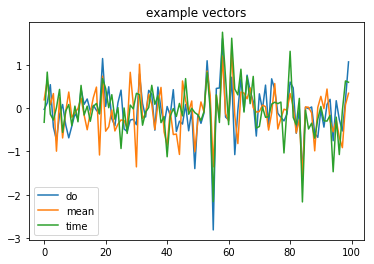

In [52]:
## Peeking at the embedding mtx values
print(embedding_mtx.shape)
plt.plot(embedding_mtx[16], label=embedding_mtx_idx[16])
plt.plot(embedding_mtx[37], label=embedding_mtx_idx[37])
plt.plot(embedding_mtx[18], label=embedding_mtx_idx[18])
plt.title('example vectors')
plt.legend()